In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
!pip install missingno
import missingno as msno

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_data.HepG2.Histone.Enhancer.csv')

In [8]:
df

,Pos,gene_name,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K79me2,H3K9ac,H3K9me3,H4K20me1,enhancer
0,chr10:100216834-100995619,HPSE2,0.0,0.0,0.0,5.81644,0.00000,0.0,0.0000,0.0,0.0,1
1,chr10:101156627-101190381,GOT1,0.0,0.0,0.0,3.98603,0.00000,0.0,0.0000,0.0,0.0,1
2,chr10:101542397-101612351,ABCC2,0.0,0.0,0.0,0.00000,0.00000,0.0,7.7407,0.0,0.0,1
3,chr10:101635334-101769704,DNMBP,0.0,0.0,0.0,5.42836,0.00000,0.0,0.0000,0.0,0.0,1
4,chr10:102132856-102213800,OLMALINC,0.0,0.0,0.0,4.81479,3.74003,0.0,0.0000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4036,chrX:9217960-9243246,AC003684.1,0.0,0.0,0.0,4.01233,0.00000,0.0,0.0000,0.0,0.0,1
4037,chrX:9983294-10112514,WWC3,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1
4038,chrX:99899192-99930785,SRPX2,0.0,0.0,0.0,0.00000,4.75055,0.0,0.0000,0.0,0.0,1
4039,chrX:9992882-10006694,WWC3-AS1,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1


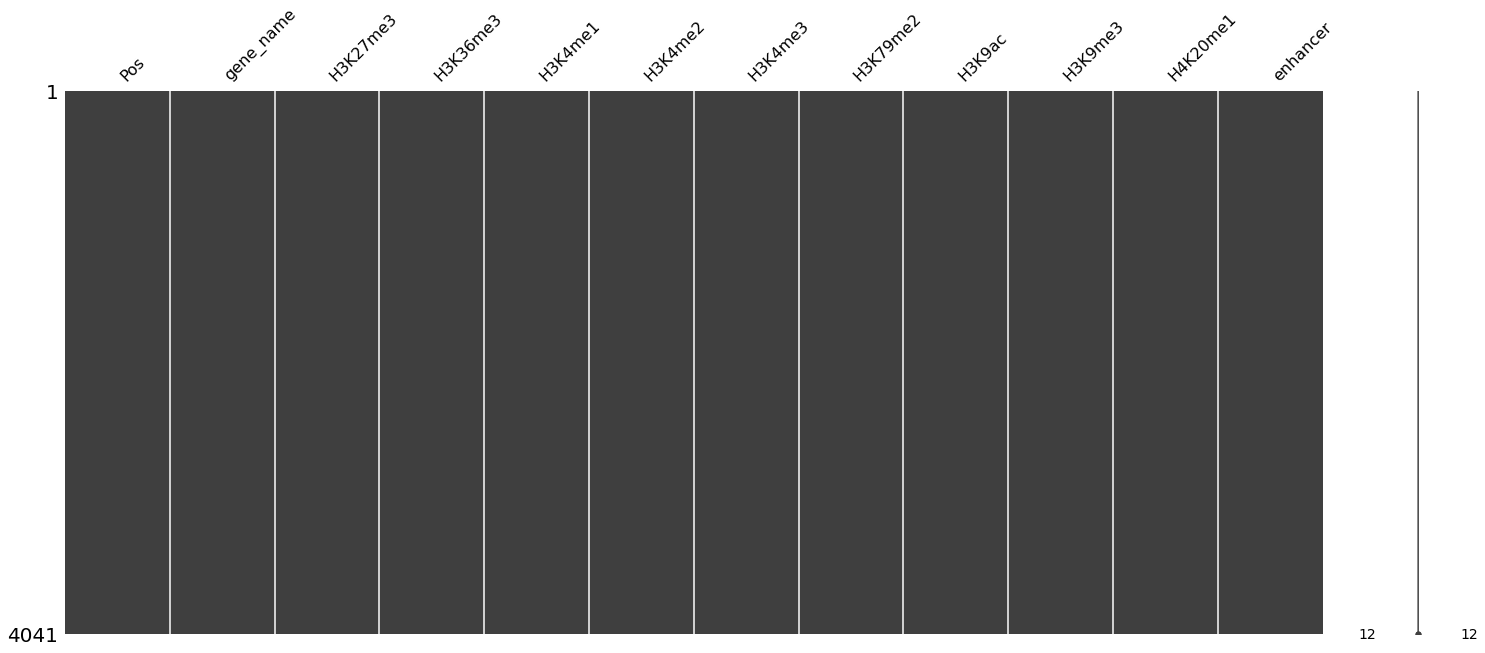

In [9]:
msno.matrix(df)

In [10]:
df.describe()

,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K79me2,H3K9ac,H3K9me3,H4K20me1,enhancer
count,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.000000,4041.0
mean,0.159542,0.062658,0.443067,2.613555,2.500195,0.451418,0.820192,0.013296,0.178646,1.0
std,0.804185,0.503420,1.420225,3.298010,3.734785,1.546432,2.211178,0.217375,0.868683,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.000000,0.000000,0.000000,4.924210,4.464960,0.000000,0.000000,0.000000,0.000000,1.0
max,7.697840,6.151080,10.669700,25.530990,53.946900,14.372830,28.984860,5.109310,7.490230,1.0


# Train Random Forest

In [11]:
df.head() # 현재 갖고있는 데이터는 gene의 위치와, 이름, 그리고 histone modification들, 이게 enhancer인지.

,Pos,gene_name,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K79me2,H3K9ac,H3K9me3,H4K20me1,enhancer
0,chr10:100216834-100995619,HPSE2,0.0,0.0,0.0,5.81644,0.00000,0.0,0.0000,0.0,0.0,1
1,chr10:101156627-101190381,GOT1,0.0,0.0,0.0,3.98603,0.00000,0.0,0.0000,0.0,0.0,1
2,chr10:101542397-101612351,ABCC2,0.0,0.0,0.0,0.00000,0.00000,0.0,7.7407,0.0,0.0,1
3,chr10:101635334-101769704,DNMBP,0.0,0.0,0.0,5.42836,0.00000,0.0,0.0000,0.0,0.0,1
4,chr10:102132856-102213800,OLMALINC,0.0,0.0,0.0,4.81479,3.74003,0.0,0.0000,0.0,0.0,1


In [14]:
X = df.values[:,2:-1].astype('float')
X

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 7.7407, 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]])

In [16]:
y = df.values[:, -1].astype('float')
y

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
from sklearn.ensemble import RandomForestClassifier # 트리에 다양한 파라미터를 넣을 수 있음. 가중치, 엔트로피, feature 추출 등..
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


#=================================== 파라미터 설정 ==========================
# Number of trees in random forest # estimator를 200~2000개 까지
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split 
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree 최대 깊이
max_depth = list(range(1,30)) 
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# 0과 1, 현재 0은 1000, 1이 5000개 정도 되는데, 균형을 맞춰줌.
class_weight = ["balanced", "balanced_subsample"]

# 연속형 범주나 많은 범주를 가진 feature들을 과대평가하는 경향이 있기 때문에 이를 완화시키는 옵션
# mean_impurity_decrease = 0 # float 형태

#=================================== 파라미터 설정 ==========================

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight' : class_weight}

In [20]:
from sklearn.model_selection import train_test_split # 테스트 데이터 분리

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)

In [21]:
import multiprocessing
multiprocessing.cpu_count() # 현재 drive에서는 계산 가능한 CPU를 2개만 할당해줌.

2

In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier() # 객체 생성

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1) # -1을 넣으면 가용 가능한 모든 CPU를 연산에 사용
# Fit the random search model
rf_random.fit(xTrain, yTrain) # 학습. 시간이 약 10분가량 걸림.

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [23]:
rf_random.cv_results_ # 여러 노드에 대한 결과들

{'mean_fit_time': array([2.18249599, 5.27202241, 0.5471317 , 0.54797904, 1.25583863,
        2.53986049, 4.46101586, 4.4555645 , 3.76557851, 3.5404524 ,
        0.42855112, 0.44595909, 4.02171429, 1.2448287 , 3.54853328,
        0.43640208, 3.53969765, 2.55513668, 3.56993214, 2.63808648,
        3.43360543, 1.25710948, 5.75793926, 3.36120598, 3.33077614,
        3.35824966, 1.6931653 , 2.26615532, 1.17329454, 1.17768383,
        0.56564633, 3.84235787, 4.30938689, 4.31453888, 1.6975379 ,
        3.9829518 , 4.35981894, 0.43964299, 2.22151629, 6.162889  ,
        3.81945976, 1.35708555, 1.79192996, 0.86727905, 4.36444267,
        4.7336154 , 0.86072842, 1.28332512, 5.69957153, 3.40421152,
        3.97500587, 3.49338635, 1.31921864, 5.74722004, 3.83323272,
        4.63998183, 0.86957979, 1.32000558, 4.43171016, 4.08611306,
        0.59983063, 8.09361021, 0.41765547, 2.16897209, 2.67491039,
        3.46760615, 7.2933863 , 2.65237991, 5.57139603, 3.78827167,
        3.65492233, 3.78182658,

In [24]:
rf_random.best_estimator_ # 가장 잘 된 모델 트리. 이하 파라미터를 갖는 애들.

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=28, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
rf_random.best_score_ # ??? 100% 모두 맞춘 모델이 나왔네???

1.0

In [26]:
rf_random.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 28,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [27]:
best_model = rf_random.best_estimator_ # 최적의 모델을 best_model이라는 객체로 복사.

# Plot feature importnace

어떤 feature가 실제적으로 중요한가를 시각화 가능.

In [28]:
best_model.feature_importances_ # 모두 균등하게 중요한가보네?

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
feature = df.columns[2:-1] # feature 이름을 갖고와서

In [30]:
feature_df = pd.DataFrame(best_model.feature_importances_, columns = ['Value']) # 그래프 그리는 용도의 df.
feature_df.index = feature # 인덱스에 이름 넣음.

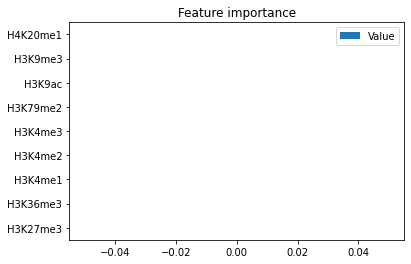

In [31]:
feature_df.plot(kind='barh', title = 'Feature importance')

In [32]:
test_result = best_model.predict(xTest)

In [33]:
best_model.score(xTest, yTest) # 테스트도 100%라고??? 뒤용

1.0

# Confusion matrix

동일하게 confusion matrix로 그려보자.

In [34]:
from sklearn.metrics import confusion_matrix

pred = best_model.predict(xTest)
confusion_matrix(yTest, pred)

array([[809]])

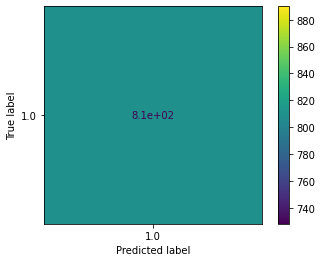

In [35]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_model, xTest, yTest) 

In [36]:
best_model.predict_proba(xTest)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [37]:
best_model.predict_proba(xTest)[:, 0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(yTest, best_model.predict_proba(xTest)[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yTest.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0],
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

metrics.plot_roc_curve(best_model, xTest, yTest)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

# Automl로 쉽게 hyperparameter tuning 하기

parameter를 알아서 최적화해줌.

In [42]:
!pip install -U pycaret

     |████████████████████████████████| 266 kB 4.9 MB/s 
     |████████████████████████████████| 113 kB 61.3 MB/s 
     |████████████████████████████████| 16.9 MB 39 kB/s 
     |████████████████████████████████| 1.7 MB 37.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 167 kB 50.4 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 58.3 MB/s 
     |████████████████████████████████| 6.8 MB 37.8 MB/s 
     |████████████████████████████████| 1.3 MB 12.9 MB/s 
     |████████████████████████████████| 261 kB 54.7 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 2.0 MB 33.7 MB/s 
     |████████████████████████████████| 62 kB 697 kB/s 
     |████████████████████████████████| 10.1 MB 38.1 MB/s 
     |████████████████████

In [43]:
df

,Pos,gene_name,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K79me2,H3K9ac,H3K9me3,H4K20me1,enhancer
0,chr10:100216834-100995619,HPSE2,0.0,0.0,0.0,5.81644,0.00000,0.0,0.0000,0.0,0.0,1
1,chr10:101156627-101190381,GOT1,0.0,0.0,0.0,3.98603,0.00000,0.0,0.0000,0.0,0.0,1
2,chr10:101542397-101612351,ABCC2,0.0,0.0,0.0,0.00000,0.00000,0.0,7.7407,0.0,0.0,1
3,chr10:101635334-101769704,DNMBP,0.0,0.0,0.0,5.42836,0.00000,0.0,0.0000,0.0,0.0,1
4,chr10:102132856-102213800,OLMALINC,0.0,0.0,0.0,4.81479,3.74003,0.0,0.0000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4036,chrX:9217960-9243246,AC003684.1,0.0,0.0,0.0,4.01233,0.00000,0.0,0.0000,0.0,0.0,1
4037,chrX:9983294-10112514,WWC3,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1
4038,chrX:99899192-99930785,SRPX2,0.0,0.0,0.0,0.00000,4.75055,0.0,0.0000,0.0,0.0,1
4039,chrX:9992882-10006694,WWC3-AS1,0.0,0.0,0.0,4.41356,0.00000,0.0,0.0000,0.0,0.0,1


In [44]:
df['enhancer'] = df['enhancer'].astype('int')

In [ ]:
from pycaret.classification import *
clf1 = setup(data = df, target = 'enhancer', ignore_features = ['Pos','gene_name']) # 정답은 enhancer칼럼, pos와 gene_name은 무시.

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:29:25
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
H3K27me3,Numeric
H3K36me3,Numeric
H3K4me1,Numeric
H3K4me2,Numeric
H3K4me3,Numeric
H3K79me2,Numeric
H3K9ac,Numeric
H3K9me3,Numeric
H4K20me1,Numeric
enhancer,Label


In [ ]:
# check the model library to see all models
models()

In [ ]:
# train rf model using 5 fold CV
rf = create_model('rf', fold = 5)

In [ ]:
tuned_rf = tune_model(rf)

In [ ]:
plot_model(tuned_rf, plot = 'auc')

In [ ]:
plot_model(tuned_rf, plot = 'pr')

In [ ]:
plot_model(tuned_rf, plot='feature')

In [ ]:
plot_model(tuned_rf, plot = 'confusion_matrix')

In [ ]:
evaluate_model(tuned_rf)

In [ ]:
best_model = compare_models()